In [31]:
import operator
import random
import requests
import time
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime

# Load the data

### Movies data

In [2]:
m_cols = ["wikipedia_m_ID", "freebase_m_ID", "m_name", "m_release_date", "m_BO_revenue", "m_runtime", "m_languages", "m_countries", "m_genres"]
df_movies=pd.read_csv('movie.metadata.tsv', sep='\t', names=m_cols, converters={'m_languages': literal_eval, 'm_countries': literal_eval, 'm_genres': literal_eval})
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')##min value of date '1010-12-02' qui plus petit que la plus petite date de to_datetime
df_movies=df_movies.where(df_movies.astype(bool),np.nan).drop_duplicates(subset=['m_name', 'm_runtime'])
df_movies.head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'}


### Characters data

In [3]:
a_cols = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date','character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'freebase_character_map', 'freebase_character_id', 'freebase_actor_id']
df_actors=pd.read_csv('character.metadata.tsv', sep='\t', names=a_cols, parse_dates=['movie_release_date'])
df_actors['movie_release_date']=pd.to_datetime(df_actors['movie_release_date'], errors = 'coerce')##min value of date '1010-12-02' qui plus petit que la plus petite date de to_datetime

#Change problematic dates
df_actors['actor_dob'] = df_actors['actor_dob'].apply(lambda x: str(x) if len(str(x)) <=10 else str(x)[:10])
df_actors['actor_dob'] = pd.to_datetime(df_actors['actor_dob'], errors = 'coerce')
df_actors.dropna(subset='actor_name', inplace=True)
df_actors.drop_duplicates(keep='first', inplace=True)
df_actors.drop_duplicates(subset=["wikipedia_movie_id", "character_name", "actor_name", "movie_release_date"], keep=False, inplace=True)
df_actors = df_actors[df_actors['actor_age'] > 0]

df_actors.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


# Movie general analysis

### Freebase movie ID

In [4]:
def check_freebase_id(x):
    id_m = x.split('/')[1]
    return id_m=='m'

In [5]:
df_movies['freebase_m_ID'].apply(lambda x: check_freebase_id(x)).value_counts()

True    81113
Name: freebase_m_ID, dtype: int64

All freebase movie ID start with '/m/'. So they are all movie wikipedia ID.

In [8]:
tot = []
k_size = 5
for k in range(k_size):
    n = 100
    rd_elements = random.sample(df_movies['freebase_m_ID'].apply(lambda x: x.split('/')[2]).to_list(), n)
    url='%28%3'
    for x in rd_elements:
        url += 'Ftitle%20%3D%20%22%2Fm%2F' + x + '%22%20%7C%7C%20%3'
    query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3Ftitle%20WHERE%20%7B%20%0A%20%20VALUES%20%3Fmovietype%20%7B%20wd%3AQ11424%7D%0A%20%20%3Fs%20p%3AP31%2Fps%3AP31%20%3Fmovietype.%0A%20%20%3Fs%20wdt%3AP646%20%3Ftitle.%0A%20%20FILTER{}%22%29%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(url[:-17])
    response = requests.get(query)
    response = response.json()['results']['bindings']
    tot.append(len(response))

print("There is around {:.2f}% of the movies that have an active wikipedia freebase ID.".format(sum(tot)/k_size))

There is around 78.00% of the movies that have an active wikipedia freebase ID.


### Movie name

In [9]:
nb_movies = df_movies[["m_name", "freebase_m_ID"]].value_counts().count()
unique_wikipedia_m_id = df_movies["wikipedia_m_ID"].count()
print("There are {} different movies, corresponding to {} different wikipedia ID.".format(nb_movies, 
                                                                                          unique_wikipedia_m_id))

There are 81113 different movies, corresponding to 81113 different wikipedia ID.


In [10]:
nb_duplicated_titles = df_movies[df_movies.duplicated('m_name', keep=False)]['wikipedia_m_ID'].count()
print("There are {} movies with duplicated titles.".format(nb_duplicated_titles))

There are 9706 movies with duplicated titles.


In [11]:
df_movies["m_name"].value_counts()

Alice in Wonderland               15
Les Misérables                    11
The Three Musketeers              11
A Christmas Carol                 11
Macbeth                           10
                                  ..
His Wife's Child                   1
Emmanuelle 3: A Lesson in Love     1
Suffering Man's Charity            1
Maa Tujhhe Salaam                  1
Spliced                            1
Name: m_name, Length: 75478, dtype: int64

One can see that when some movies have the same title, it mainly corresponds to either remake movies or common titles where movies have nothing in common.

### Movie release date

In [12]:
nb_movies_with_release_date = df_movies['m_release_date'].dropna().count()
print("There are {} movies with a known release date. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_release_date, nb_movies_with_release_date / nb_movies * 100))

There are 73965 movies with a known release date. It corresponds to 91.19 % of the movies.


Histogram of release date

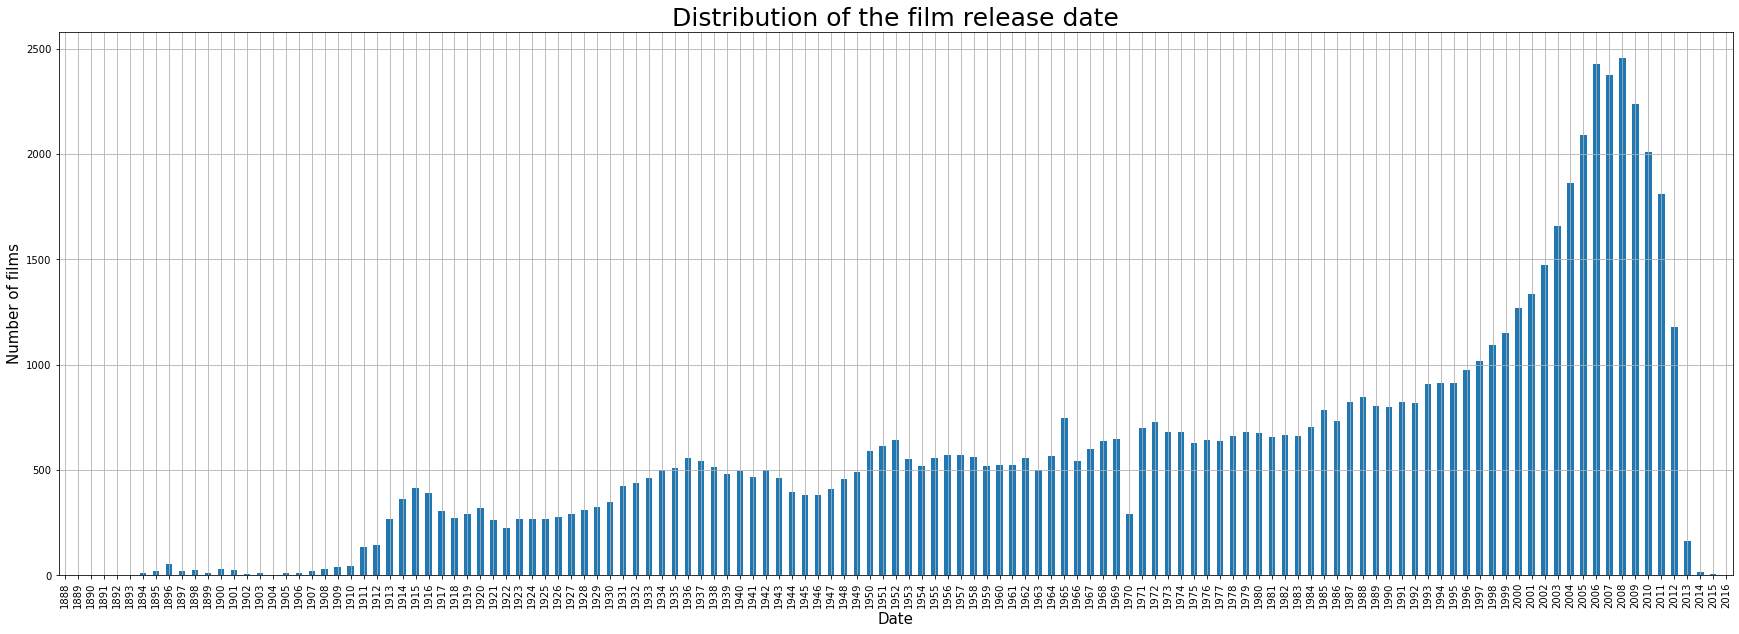

The dataset is composed of 


In [13]:
df_movies['m_release_date'].dropna().dt.year.sort_values().value_counts(sort=False).plot(kind='bar', figsize=(30,10))
plt.grid()
plt.title('Distribution of the film release date', fontsize=25)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of films', fontsize=15)
plt.show()
print("The dataset is composed of ")

In [32]:
feature_wiki_ID={
    "runtime": 'AP2047',
    "pubdate":'AP577'
}

def get_freebase_feature(row, value, op, n_lim, feature):
    ops = {
    '>=' : operator.ge,
    '<=' : operator.le,
    '>' : operator.gt,
    '<' : operator.lt,
    }
    op = ops[op]
    val_to_compare = value
    if feature == 'pubdate':
        val_to_compare=value.year
    if op(val_to_compare, n_lim):
        id_m = str(row['freebase_m_ID'].split('/')[2])
        query = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%20%3FoLabel%20%3F{}%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F{}%22.%0A%20%3Fs%20wdt%3{}%20%3F{}.%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D'.format(feature, id_m, feature_wiki_ID[feature], feature)
        response = requests.get(query)
        response_json = response.json()
        if len(response_json['results']['bindings']):
            if feature == 'runtime':
                new_value = float(response_json['results']['bindings'][0][feature]['value'])
                if new_value!=value:
                    time.sleep(5)
                    print("{} movie had a {} of {}. However, using freebase ID, {}={}min.".format(row['m_name'], feature,
                                                                                               value, feature, 
                                                                                               new_value))
                    value = new_value
            elif feature=='pubdate':
                new_value = (response_json['results']['bindings'][0][feature]['value'])
                new_value=new_value.replace("Z", "")
                new_value = datetime.strptime(new_value,'%Y-%m-%dT%H:%M:%S')
                if new_value.year!=value.year:
                    print("{} movie had a {} of {}. However, using freebase ID, {}={}.".format(row['m_name'], feature,
                                                                                               value.date(), feature, 
                                                                                               new_value.date()))
                    value = new_value
            
    return value

In [15]:
df_movies['m_release_date'] = df_movies[['m_release_date', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature(row, row['m_release_date'], '>=', 2015, 'pubdate'), axis=1)

Avatar 2 movie had a pubdate of 2015-01-01. However, using freebase ID, pubdate=2022-12-14.
Total Dhamaal movie had a pubdate of 2015-01-01. However, using freebase ID, pubdate=2018-12-07.
Battle Angel movie had a pubdate of 2016-01-01. However, using freebase ID, pubdate=2019-02-06.


As the dataset is not representative after 2015, the analysis will only be done with movies released before 2015.


In [16]:
df_movies = df_movies[df_movies['m_release_date'].dt.year < 2015]

### Movie box office

In [17]:
nb_movies_with_BO = df_movies['m_BO_revenue'].dropna().count()
print("There are {} movies with a known box office revenue. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_BO, nb_movies_with_BO / nb_movies * 100))

There are 8296 movies with a known box office revenue. It corresponds to 10.23 % of the movies.


Histogram of box office

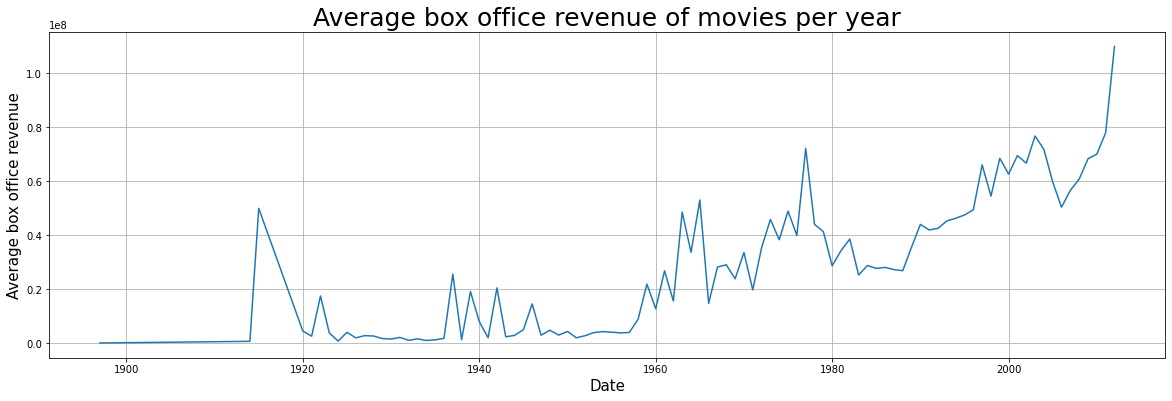

In [18]:
df_movies.groupby(df_movies.m_release_date.dt.year).mean()['m_BO_revenue'].dropna().plot(figsize=(20,6))
plt.grid()
plt.xlabel('Date', fontsize=15)
plt.ylabel('Average box office revenue', fontsize=15)
plt.title('Average box office revenue of movies per year', fontsize=25)
plt.show()

### Movie runtime

In [19]:
nb_movies_with_runtime = df_movies['m_runtime'].dropna().count()
print("There are {} movies with a known runtime duration. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_runtime, nb_movies_with_runtime / nb_movies * 100))

There are 58267 movies with a known runtime duration. It corresponds to 71.83 % of the movies.


Histogram of the runtime

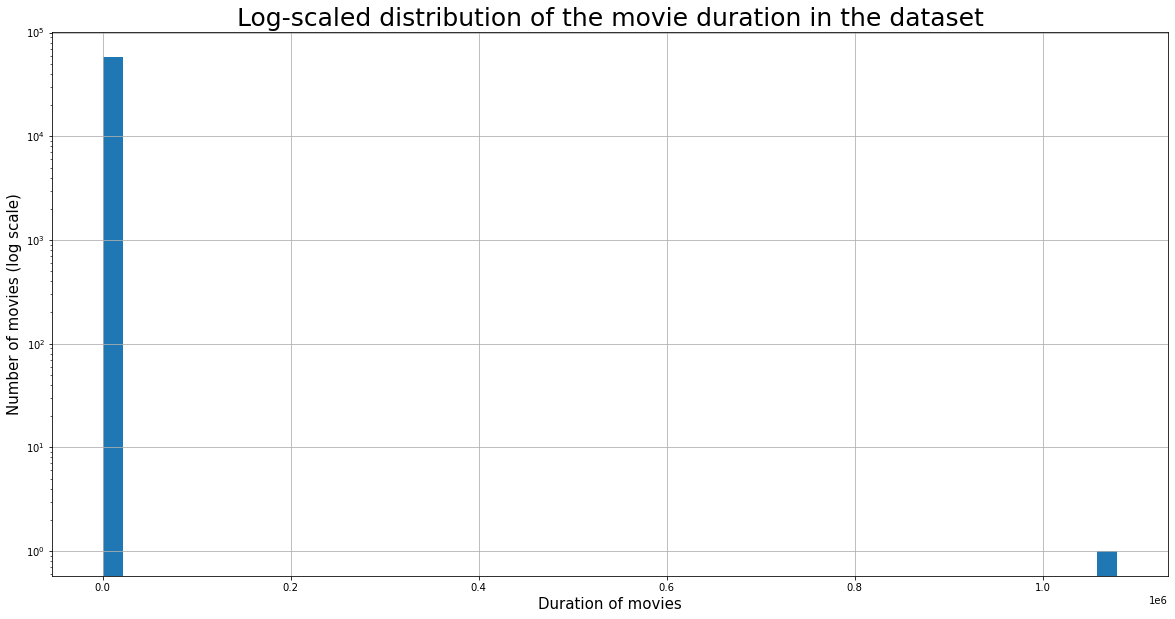

In [20]:
plt.figure(figsize=(20,10))
df_movies.m_runtime.hist(bins=50)
plt.yscale('log')
plt.ylabel('Number of movies (log scale)', fontsize=15)
plt.xlabel('Duration of movies', fontsize=15)
plt.title("Log-scaled distribution of the movie duration in the dataset", fontsize=25)
plt.show()

In [21]:
nb_movies_duration_inf_1 = df_movies[(df_movies['m_runtime']>= 1500)]['wikipedia_m_ID'].count()
nb_movies_duration_supp_1500 = df_movies[(df_movies['m_runtime']<= 1)]['wikipedia_m_ID'].count()
print("There are {} movies which a runtime > 1500 and {} movies with a runtime < 1.".format(nb_movies_duration_inf_1, nb_movies_duration_supp_1500))

There are 12 movies which a runtime > 1500 and 87 movies with a runtime < 1.


One can see that there are some outliers in the runtime. It might be due to the time conversion. As the runtime input is supposed to be in minutes, freebase ID will be queried using wikidata to know whether the runtime is the correct one.

In [33]:
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature(row, row['m_runtime'], '>', 1500, 'runtime'), axis=1)
df_movies['m_runtime'] = df_movies[['m_runtime', 'freebase_m_ID', 'm_name']].apply(lambda row: get_freebase_feature(row, row['m_runtime'], '<', 1, 'runtime'), axis=1)

Zero Tolerance movie had a runtime of 1079281.0. However, using freebase ID, runtime=88.0s.
Dhool Ka Phool movie had a runtime of 1533.0. However, using freebase ID, runtime=153.0s.
Cinématon movie had a runtime of 9360.0. However, using freebase ID, runtime=11828.0s.
Dil Ne Phir Yaad Kiya movie had a runtime of 1966.0. However, using freebase ID, runtime=148.0s.
As Seen Through a Telescope movie had a runtime of 0.7. However, using freebase ID, runtime=55.0s.
Men Boxing movie had a runtime of 0.0833333333333. However, using freebase ID, runtime=5.0s.
Fred Ott's Sneeze movie had a runtime of 0.0833333333333. However, using freebase ID, runtime=4.0s.
Sick Kitten movie had a runtime of 0.566666666667. However, using freebase ID, runtime=34.0s.
The X-Rays movie had a runtime of 0.733333333333. However, using freebase ID, runtime=44.0s.
Blacksmith Scene movie had a runtime of 0.566666666667. However, using freebase ID, runtime=34.0s.
L'Arroseur Arrosé movie had a runtime of 0.816666666667.

The new distribution of runtimes among movies can now be computed.

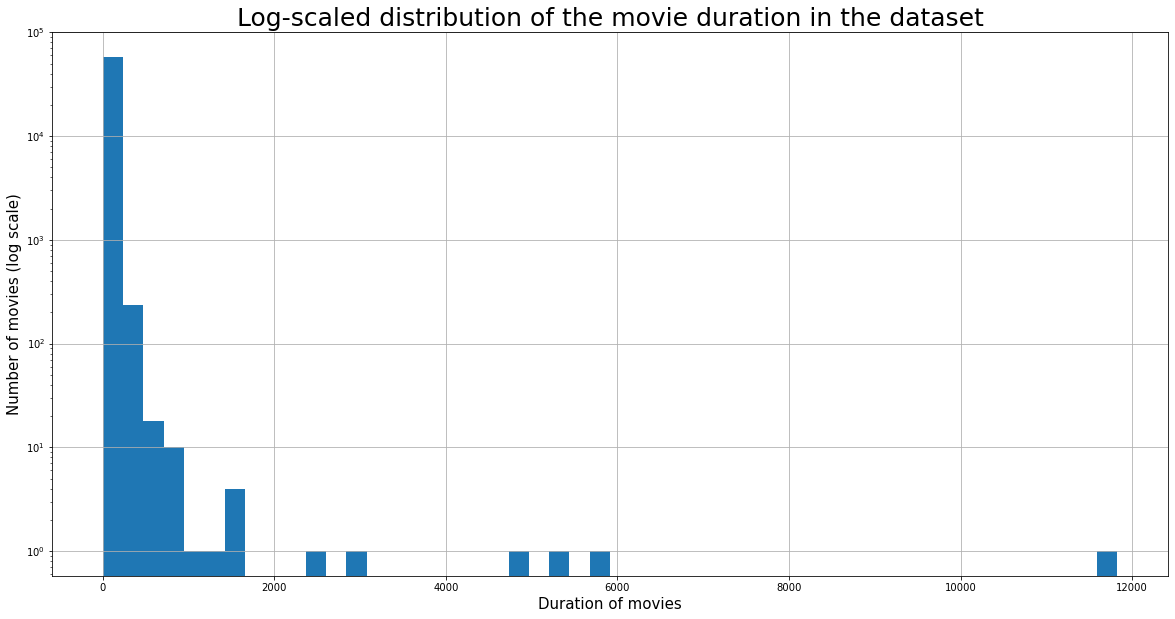

In [34]:
plt.figure(figsize=(20,10))
df_movies.m_runtime.hist(bins=50)
plt.yscale('log')
plt.ylabel('Number of movies (log scale)', fontsize=15)
plt.xlabel('Duration of movies (min)', fontsize=15)
plt.title("Log-scaled distribution of the movie duration in the dataset", fontsize=25)
plt.show()

The average duration of a movie throughout the years is now studied. A bootstrap version is computed. 

In [564]:
#Boostrap confidence interval function
def bootstrap_CI(data, nbr_draws):
    """
    Args:
    - data: 
    - nbr_draws: 
    
    Returns: confidence interval
    """
    means = np.zeros(nbr_draws)
    data = np.array(data)
    print(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


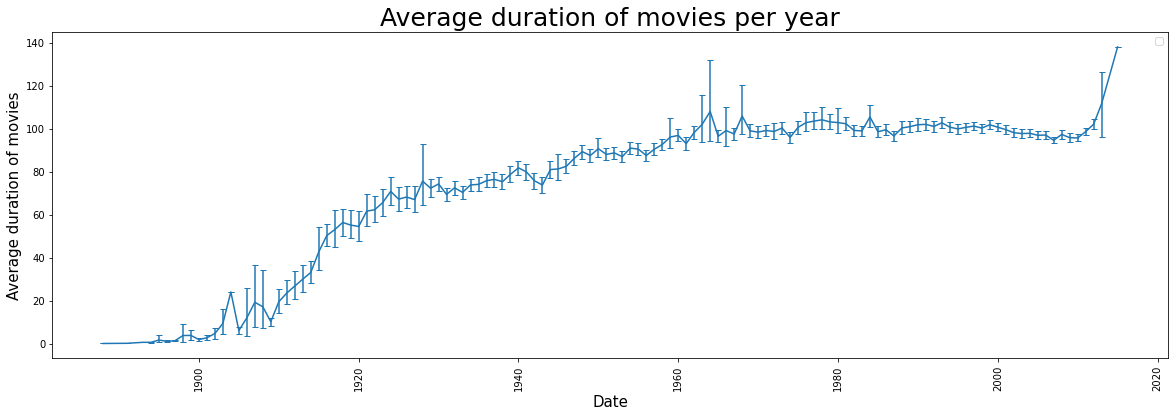

In [244]:
merge = df_movies.m_release_date.dt.year

stat = df_movies[df_movies['m_runtime']<5000][['m_release_date', 'm_runtime']].dropna().groupby(merge).apply(lambda x: pd.Series({
    'average_runtime': x['m_runtime'].mean(),
    'lower_err_runtime': bootstrap_CI(x['m_runtime'], 3000)[0],
    'upper_err_runtime': bootstrap_CI(x['m_runtime'], 3000)[1]
}))

plt.figure(figsize=(20,6))
plt.errorbar(stat.index, stat.average_runtime,
         yerr = [-stat.lower_err_runtime + stat.average_runtime, 
                -stat.average_runtime + stat.upper_err_runtime],
         capsize= 3)
plt.xlabel('Date', fontsize=15)
plt.xticks(rotation=90)
plt.grid()
plt.ylabel('Average duration of movies', fontsize=15)
plt.title('Average duration of movies per year', fontsize=25)
plt.show()

### Movie dataset preparation

In [39]:
def split_feature(row, feature, flag):
    if isinstance(row[feature], float):
        return np.nan
    elif flag:
        return list(row[feature].values())
    else:
        return row[feature].keys()

In [40]:
features=['m_languages', 'm_countries', 'm_genres']
_freebase_ID='_freebase_ID'
for i, feature in enumerate(features):
    df_movies[feature+_freebase_ID]=df_movies.apply(lambda row: split_feature(row, feature, 0), axis=1)
    df_movies[feature]=df_movies.apply(lambda row: split_feature(row, feature, 1), axis=1)

### Movie genres

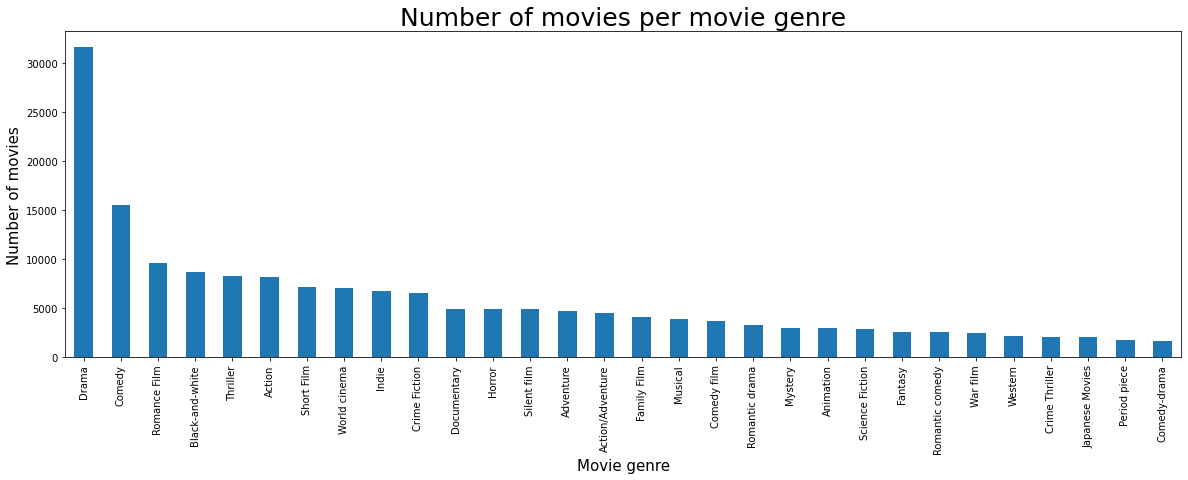

In [43]:
df_genres_m = df_movies.explode('m_genres').dropna(subset='m_genres')
df_genres_m['m_genres'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

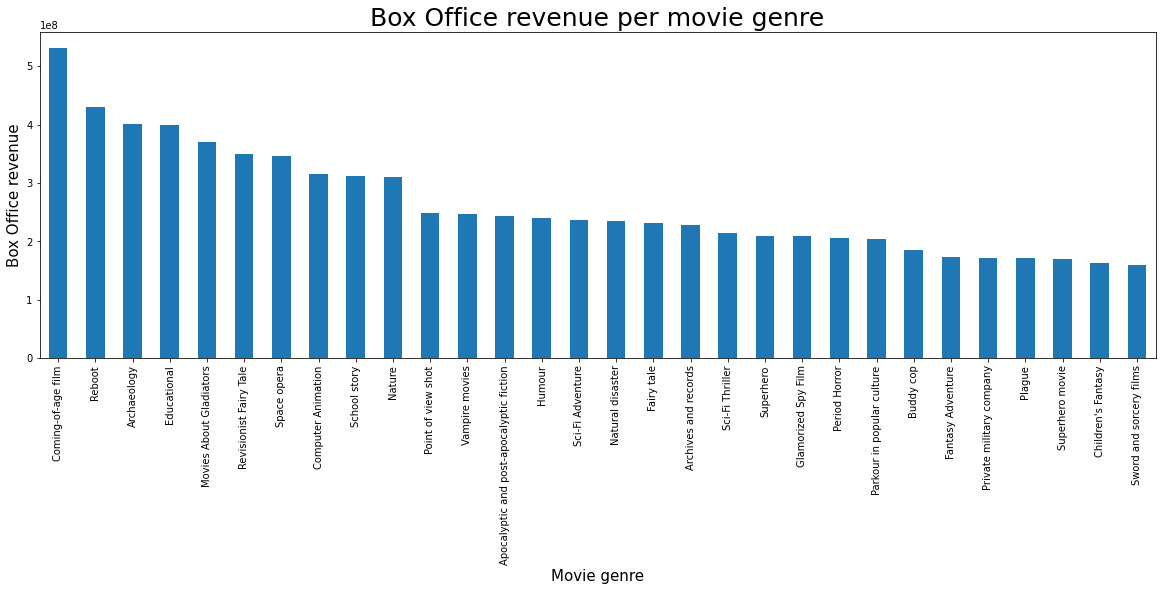

In [45]:
#df_genre_merged_m = df_genres_m.merge(df_movies, left_on='wikipedia_m_ID', right_on='wikipedia_m_ID')
plt.figure(figsize=(20,6))
df_genres_m[["m_BO_revenue", "m_genres"]].dropna().groupby('m_genres')['m_BO_revenue'].mean().sort_values(ascending=False)[:30].plot(kind='bar')
plt.title('Box Office revenue per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Box Office revenue', fontsize = 15)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


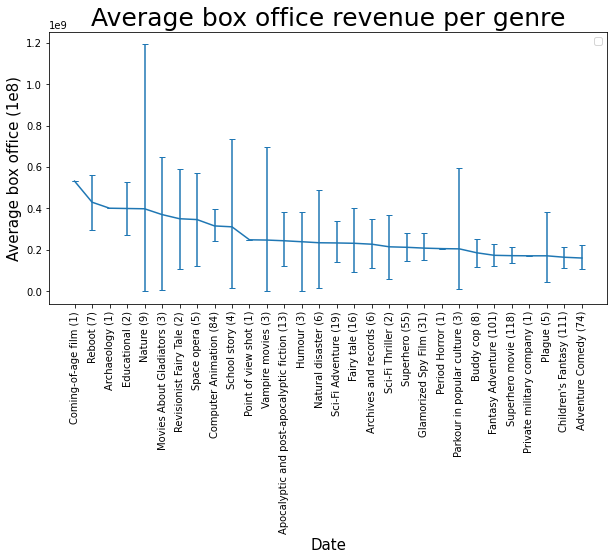

In [126]:
merge = 'm_genres'

stat = df_genres_m.dropna().groupby(merge).apply(lambda x: pd.Series({
    'average_bo': x['m_BO_revenue'].mean(),
    'lower_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[0],
    'upper_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[1]
}))

plt.figure(figsize=(10,5))
stat = stat.sort_values("average_bo", ascending=False)

labels = stat.index[:30]
labels_hist = df_genres_m.dropna(subset='m_BO_revenue')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_bo[:30],
         yerr = [-stat.lower_err_bo[:30] + stat.average_bo[:30], 
                -stat.average_bo[:30] + stat.upper_err_bo[:30]],
         capsize= 3)
plt.xlabel('Movie genre', fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Average box office (1e8)', fontsize=15)
plt.grid()
plt.title('Average box office revenue per genre', fontsize=25)
plt.show()

In [54]:
df_genre_a= df_genres_m.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id').dropna()

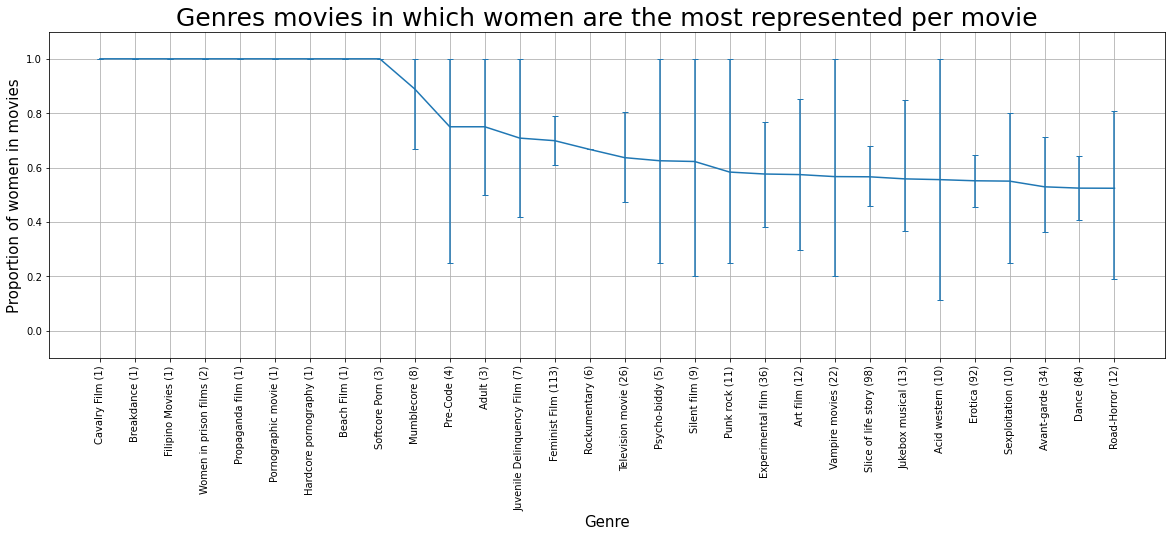

In [131]:
merge = ['m_genres']

df_temp = df_genre_a[['wikipedia_m_ID', 'm_genres', 'actor_gender']].copy()

df_temp['actor_gender'] = df_temp['actor_gender'].apply(lambda x: 1 if x=='F' else 0)

stat = df_temp.dropna(subset=['actor_gender', 'm_genres']).groupby(['m_genres', 'wikipedia_m_ID']).mean().groupby(merge).apply(lambda x: pd.Series({
    'average_gender': x['actor_gender'].mean(),
    'lower_err_gender': bootstrap_CI(x['actor_gender'], 1000)[0],
    'upper_err_gender': bootstrap_CI(x['actor_gender'], 1000)[1]
}))

plt.figure(figsize=(20,6))
stat = stat.sort_values("average_gender", ascending=False)

labels = stat.index[:30]
labels_hist = df_temp.dropna(subset='actor_gender')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_gender[:30],
         yerr = [-stat.lower_err_gender[:30] + stat.average_gender[:30], 
                -stat.average_gender[:30] + stat.upper_err_gender[:30]],
         capsize= 3)

plt.ylim(-0.1, 1.1)
plt.grid()
plt.xticks(rotation=90)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Genres movies in which women are the most represented per movie', fontsize=25)
plt.show()

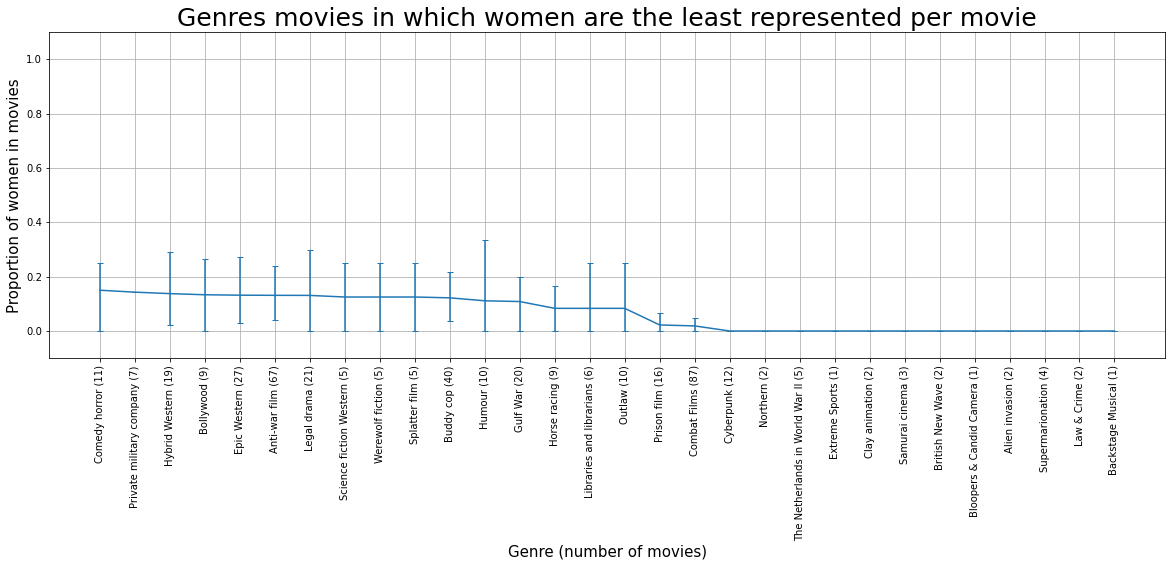

In [132]:
plt.figure(figsize=(20,6))
stat = stat.sort_values("average_gender", ascending=False)

labels = stat.index[-30:]
labels_hist = df_temp.dropna(subset='actor_gender')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_gender[-30:],
         yerr = [-stat.lower_err_gender[-30:] + stat.average_gender[-30:], 
                -stat.average_gender[-30:] + stat.upper_err_gender[-30:]],
         capsize= 3)

plt.xticks(rotation=90)
plt.ylim(-0.1, 1.1)
plt.grid()
plt.xlabel('Genre (number of movies)', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Genres movies in which women are the least represented per movie', fontsize=25)
plt.show()

### Country of production

In [180]:
df_countries_m = df_movies.explode('m_countries').dropna(subset='m_countries')
nb_unique_countries = df_countries_m['m_countries'].nunique()
print("There are {} different countries present in the dataset.".format(nb_unique_countries))

There are 146 different countries present in the dataset.


Check to know if there were two identical country of production for a same movie.

In [189]:
df_countries_m[df_countries_m.duplicated(['m_countries', 'wikipedia_m_ID'], keep=False)]

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_languages_freebase_ID,m_countries_freebase_ID,m_genres_freebase_ID


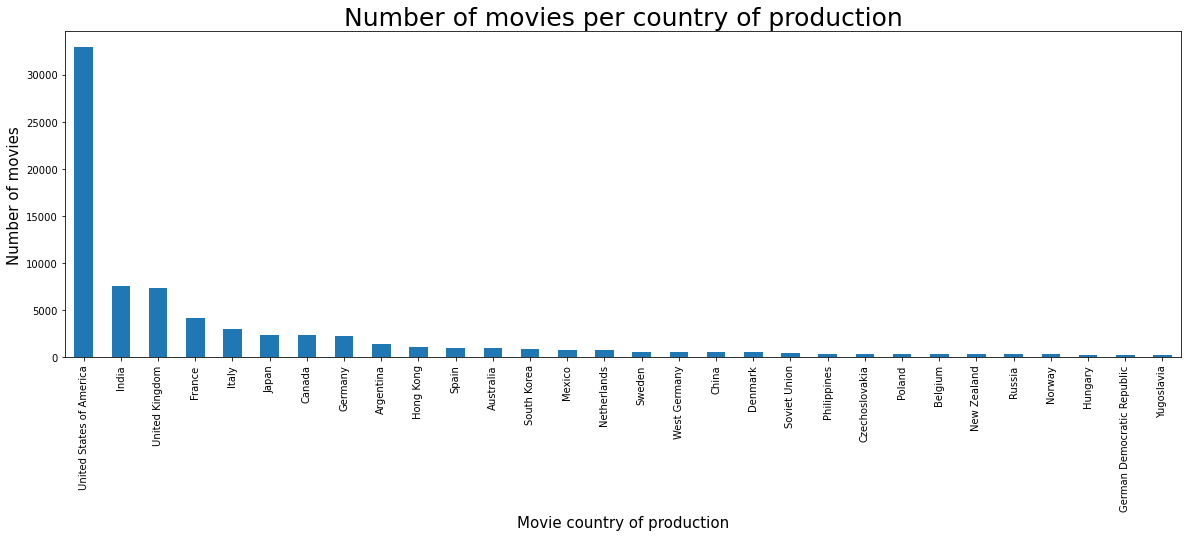

In [583]:
df_countries_m['m_countries'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per country of production', fontsize = 25)
plt.xlabel('Movie country of production', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [155]:
nb_movies_with_countries = df_countries_m.dropna(subset='m_countries')['wikipedia_m_ID'].nunique()
print("There are {} movies with a known country of production. It corresponds to {:.2f} % of the movies.".format(nb_movies_with_countries, nb_movies_with_countries / nb_movies * 100))

There are 68819 movies with a known runtime duration. It corresponds to 84.84 % of the movies.


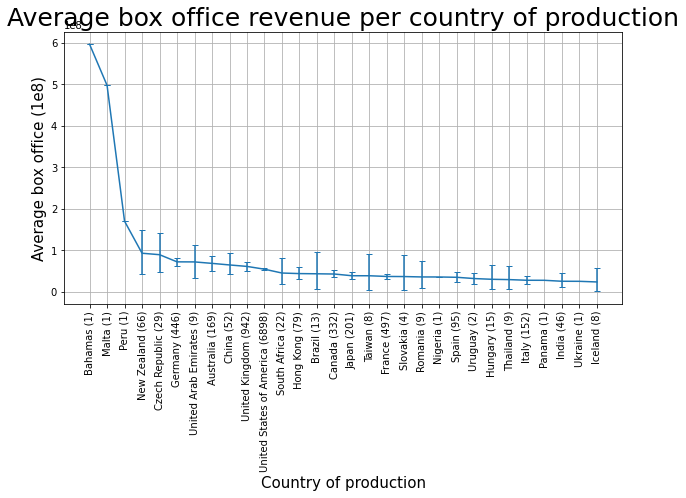

In [141]:
merge = 'm_countries'

stat = df_countries_m.dropna(subset=['m_BO_revenue', 'm_countries']).groupby(merge).apply(lambda x: pd.Series({
    'average_bo': x['m_BO_revenue'].mean(),
    'lower_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[0],
    'upper_err_bo': bootstrap_CI(x['m_BO_revenue'], 1000)[1]
}))

plt.figure(figsize=(20,6))
stat = stat.sort_values("average_bo", ascending=False)

labels = stat.index[:30]
labels_hist = df_countries_m.dropna(subset='m_BO_revenue')['m_countries'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_bo[:30],
         yerr = [-stat.lower_err_bo[:30] + stat.average_bo[:30], 
                -stat.average_bo[:30] + stat.upper_err_bo[:30]],
         capsize= 3)
plt.xlabel('Country of production', fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Average box office (1e6)', fontsize=15)
plt.grid()
plt.title('Average box office revenue per country of production', fontsize=25)
plt.show()

In [152]:
nb_value_BO_USA = df_countries_m.dropna(subset='m_BO_revenue')['m_countries'].value_counts()['United States of America']
print("American movies with known box office revenue represent {:.2f}% of all the movies with a known box office revenue.".format(nb_value_BO_USA/nb_movies_with_BO *100))

American movies with known box office revenue represent 83.15% of all the movies with a known box office revenue


### Movie languages

In [181]:
df_languages_m = df_movies.explode('m_languages').dropna(subset='m_languages')
nb_unique_languages = df_languages_m['m_languages'].nunique()
print("There are {} different languages present in the dataset.".format(nb_unique_languages))

There are 204 different languages present in the dataset.


Check to know if there were two identical languages of production for a same movie.

In [190]:
df_languages_m[df_languages_m.duplicated(['m_languages', 'wikipedia_m_ID'], keep=False)]

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_languages_freebase_ID,m_countries_freebase_ID,m_genres_freebase_ID


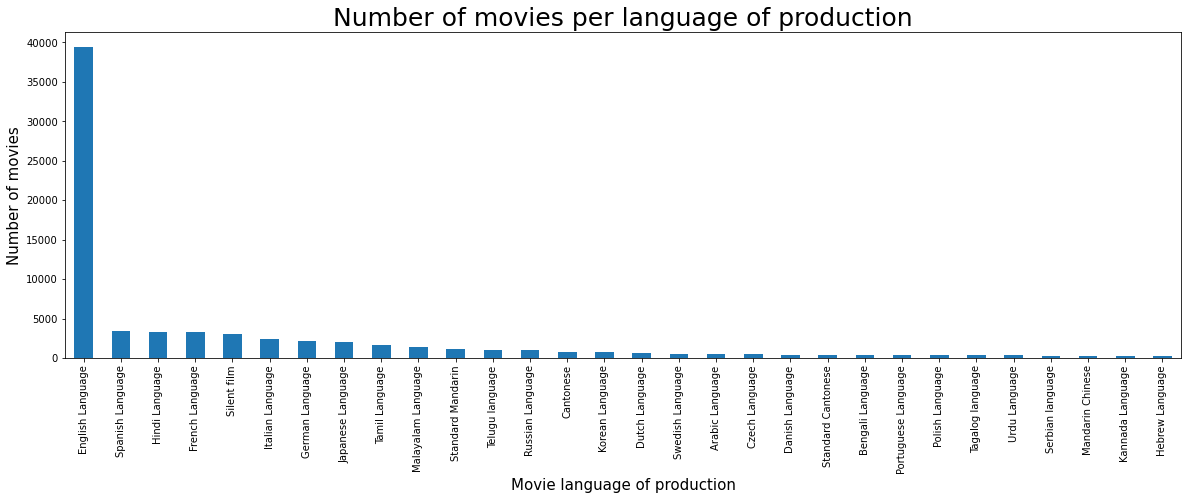

In [158]:
df_languages_m['m_languages'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per language of production', fontsize = 25)
plt.xlabel('Movie language of production', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [182]:
nb_value_BO_english = df_languages_m.dropna(subset='m_BO_revenue')['m_languages'].value_counts()['English Language']
print("English language movies with known box office revenue represent {:.2f}% of all the movies with a known box office revenue.".format(nb_value_BO_english/nb_movies_with_BO *100))

English language movies with known box office revenue represent 88.74% of all the movies with a known box office revenue.


# Zoom on American movies

In [193]:
df_movies_USA = df_countries_m[df_countries_m['m_countries']=='United States of America']
df_m_a = df_movies_USA.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id')

In [196]:
df_movies_USA.describe()

,wikipedia_m_ID,m_BO_revenue,m_runtime
count,3.294100e+04,6.898000e+03,28923.000000
mean,1.349524e+07,5.470920e+07,88.089787
std,1.039122e+07,1.214413e+08,46.731341
min,3.217000e+03,1.047400e+04,0.050000
25%,4.028951e+06,2.400000e+06,77.000000
50%,1.195860e+07,1.300000e+07,91.000000
75%,2.206910e+07,4.979346e+07,102.000000
max,3.750192e+07,2.782275e+09,5220.000000


### Movie genres

In [200]:
df_genres_m_USA = df_movies_USA.explode('m_genres')

In [204]:
nb_genres_USA = df_genres_m_USA['m_genres'].nunique()
print("There are {} different genre in american movies.".format(nb_genres_USA))

There are 341 different genre in american movies.


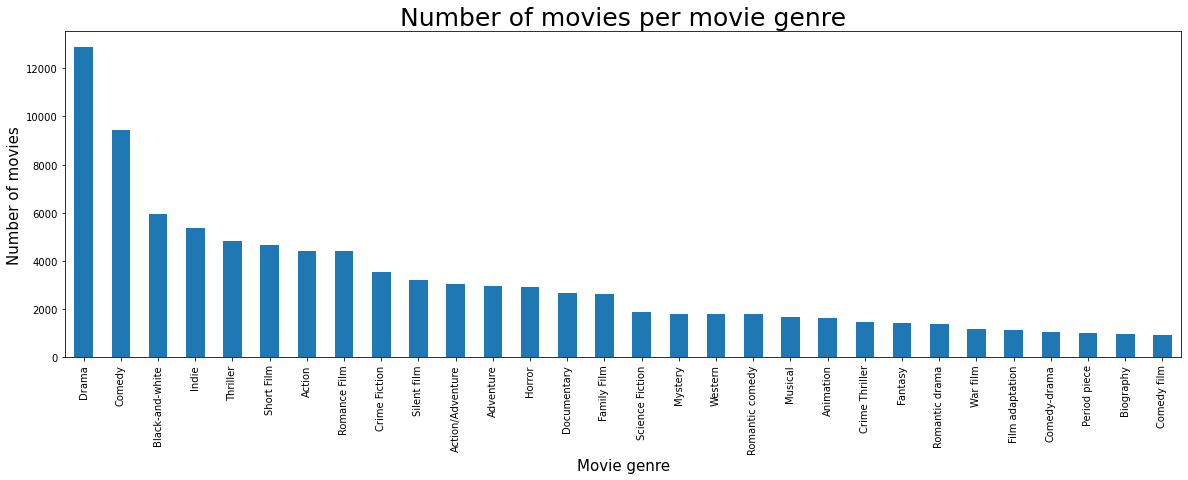

In [208]:
plt.figure(figsize=(20,6))
df_genres_m_USA['m_genres'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

In [239]:
def one_hot_encoding(df, col):
    y = pd.get_dummies(df[col])
    return y, y.columns

In [240]:
one_hot, genres_one_hot_labels = one_hot_encoding(df_genres_m_USA, 'm_genres')
df_USA_genres_one_hot = pd.concat([df_genres_m_USA, one_hot], axis=1)
df_USA_genres_one_hot = df_USA_genres_one_hot.groupby('wikipedia_m_ID')[genres_one_hot_labels].sum()

In [255]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_features = scaler.fit_transform(df_USA_genres_one_hot)

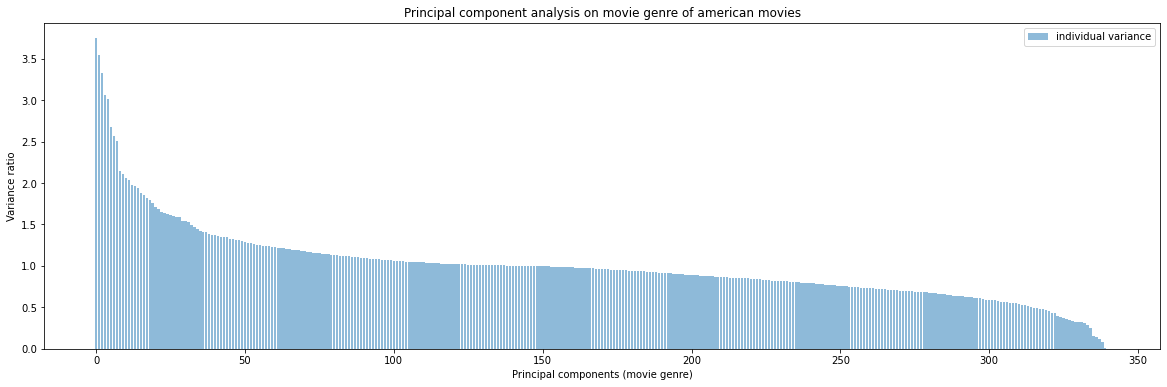

In [529]:
n=nb_genres_USA
pca = PCA(n)
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

plt.figure(figsize=(20, 6))
plt.bar(range(n), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components (movie genre)')
plt.title('Principal component analysis on movie genre of american movies')
plt.show()

In [525]:
n=10
pca = PCA(n)
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

In [526]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
#second_most_important = [np.argsort(np.abs(pca.components_[i]))[::-1][1] for i in range(n_pcs)]

#most_important = [(pca.components_[i]).argmax() for i in range(n_pcs)]
second_most_important = [np.argsort(np.abs(pca.components_[i]))[0] for i in range(n_pcs)]

initial_feature_names = genres_one_hot_labels
# get the names


most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
second_most_important_names = [initial_feature_names[second_most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic_1 = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

dic_2 = {'PC{}'.format(i): second_most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_1 = pd.DataFrame(dic_1.items())
df_2 = pd.DataFrame(dic_2.items())

df = pd.concat([df_1, df_2], axis=1)

list_best_1 = list(df_1[1])
list_best_2 = list(df_2[1])

In [527]:
nb_movies_USA_with_genre = df_genres_m_USA.dropna(subset='m_genres')['wikipedia_m_ID'].nunique()
output = []
for x in list_best_1:
    if x not in output:
        output.append(x)
#for x in list_best_2:
    #if x not in output:
        #output.append(x) 
#output = output[:40]
nb_USA_genres_reduced = df_genres_m_USA[df_genres_m_USA['m_genres'].isin(output)]['wikipedia_m_ID'].nunique()
print("Selecting n={} genres, the new dataset consists of {} american movies, which represent {:.2f}% of american movies with a known genre.".format(len(output), nb_USA_genres_reduced, nb_USA_genres_reduced/nb_movies_USA_with_genre*100))

df_USA_genres_reduced = df_genres_m_USA[df_genres_m_USA['m_genres'].isin(output)]

Selecting n=10 genres, the new dataset consists of 17972 american movies, which represent 54.70% of american movies with a known genre.


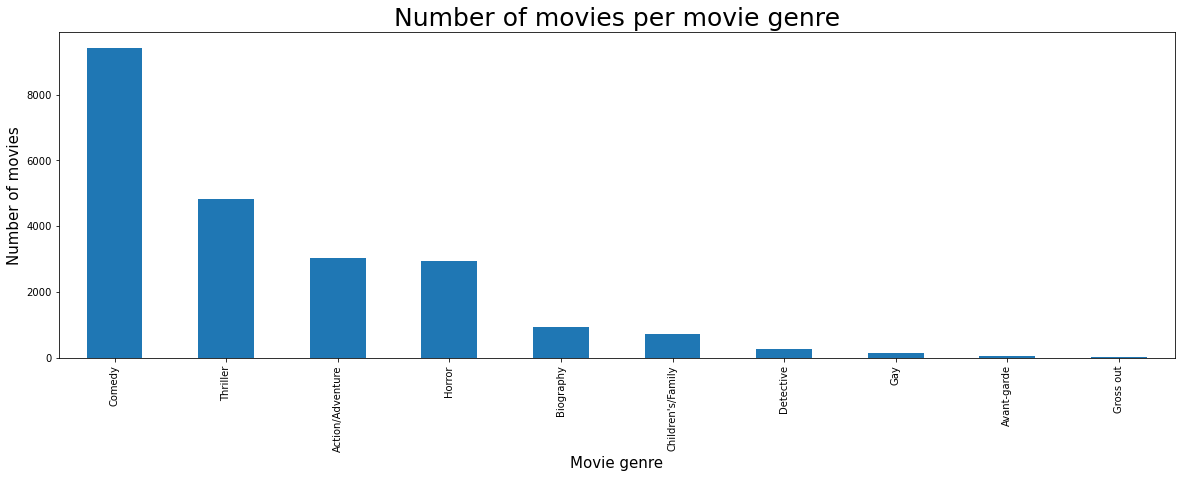

In [528]:
plt.figure(figsize=(20,6))
df_USA_genres_reduced['m_genres'].value_counts()[:30].plot(kind='bar', figsize=(20,6))
plt.title('Number of movies per movie genre', fontsize = 25)
plt.xlabel('Movie genre', fontsize = 15)
plt.ylabel('Number of movies', fontsize = 15)
plt.show()

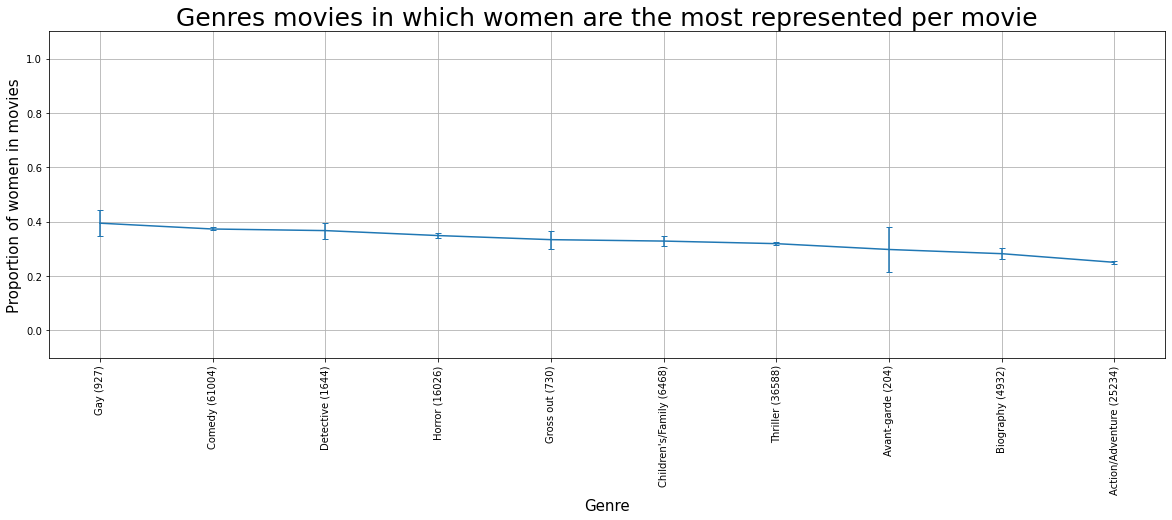

In [530]:
merge = ['m_genres']
df_temp = df_USA_genres_reduced.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id')
df_temp['actor_gender'] = df_temp['actor_gender'].apply(lambda x: 1 if x=='F' else 0)

stat = df_temp.dropna(subset=['actor_gender', 'm_genres']).groupby(['m_genres', 'wikipedia_m_ID']).mean().groupby(merge).apply(lambda x: pd.Series({
    'average_gender': x['actor_gender'].mean(),
    'lower_err_gender': bootstrap_CI(x['actor_gender'], 1000)[0],
    'upper_err_gender': bootstrap_CI(x['actor_gender'], 1000)[1]
}))

plt.figure(figsize=(20,6))
stat = stat.sort_values("average_gender", ascending=False)

labels = stat.index[:30]
labels_hist = df_temp.dropna(subset='actor_gender')['m_genres'].value_counts()
labels_mapping = labels.map(labels_hist)
labels = [x + ' ({})'.format(labels_mapping[i]) for i, x in enumerate(labels)]

plt.errorbar(labels, stat.average_gender[:30],
         yerr = [-stat.lower_err_gender[:30] + stat.average_gender[:30],
                -stat.average_gender[:30] + stat.upper_err_gender[:30]],
         capsize= 3)

plt.ylim(-0.1, 1.1)
plt.grid()
plt.xticks(rotation=90)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Distribution of the proportion of women with the reduced genre selection', fontsize=25)
plt.show()

### Actor representation

In [580]:
#Boostrap confidence interval function
def bootstrap_CI(data, nbr_draws):
    """
    Args:
    - data: 
    - nbr_draws: 
    
    Returns: confidence interval
    """
    means = np.zeros(nbr_draws)
    data = np.array(data)
    print(data)
    print(len(data))

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

In [578]:
df_temp.reset_index()

,wikipedia_m_ID,actor_gender
0,3217,0.250000
1,3333,1.000000
2,3746,0.230769
3,3837,0.100000
4,4227,0.222222
...,...,...
24817,36956792,0.200000
24818,37067980,0.250000
24819,37090987,0.333333
24820,37373877,0.600000


In [582]:
merge = ['wikipedia_m_ID']


#distrib = [df_m_a, df_countries_m.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id')]
distrib = [df_m_a]
stats_comparison = []

for df in distrib:
    df_temp = df[['actor_gender', 'wikipedia_m_ID']].copy()
    df_temp['actor_gender'] = df_temp['actor_gender'].apply(lambda x: 1 if x=='F' else 0)
    df_temp = df_temp.dropna(subset=['actor_gender']).groupby(merge).mean().reset_index()
    print("temp", df_temp)
    stat = df_temp.apply(lambda x: pd.Series({
        'average_gender': x['actor_gender'].mean(),
        'lower_err_gender': bootstrap_CI(x['actor_gender'], 1)[0],
        'upper_err_gender': bootstrap_CI(x['actor_gender'], 1)[1]
    }), axis=1)
    stats_comparison.append(stat)

print(stats_comparison[0])

plt.figure(figsize=(20,6))
for stat in stats_comparison:
    print(stat.index)
    labels = stat.index

    plt.errorbar(labels, stat.average_gender,
             yerr = [-stat.lower_err_gender + stat.average_gender,
                    -stat.average_gender + stat.upper_err_gender],
             capsize= 3)

plt.ylim(-0.1, 1.1)
plt.grid()
plt.xticks(rotation=90)
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Proportion of women in movies', fontsize=15)
plt.title('Distribution of the proportion of women in the american movies', fontsize=25)
plt.show()

temp        wikipedia_m_ID  actor_gender
0                3217      0.250000
1                3333      1.000000
2                3746      0.230769
3                3837      0.100000
4                4227      0.222222
...               ...           ...
24817        36956792      0.200000
24818        37067980      0.250000
24819        37090987      0.333333
24820        37373877      0.600000
24821        37501922      0.500000

[24822 rows x 2 columns]
0.25


TypeError: len() of unsized object

In [533]:
df_m_a.head()

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_languages_freebase_ID,...,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),...,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),...,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),...,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),...,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",(/m/02h40lc),...,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


# Trials de merde

In [36]:
df_stats = df_m_metadata.dropna()
stats.pearsonr(df_stats['m_runtime'],df_stats['m_BO_revenue'])

(0.18841035542600248, 9.896630595218262e-67)

In [37]:
stats.spearmanr(df_stats['m_runtime'],df_stats['m_BO_revenue'])

SpearmanrResult(correlation=0.2921460095802968, pvalue=7.071883787385542e-162)

In [39]:
stats.pearsonr(df_stats['m_release_date'].dt.year, df_stats['m_BO_revenue'])

(0.18617420302864984, 3.5800353668133654e-65)

In [40]:
stats.spearmanr(df_stats['m_release_date'].dt.year, df_stats['m_BO_revenue'])

SpearmanrResult(correlation=0.19657088813953413, pvalue=1.3786339719332025e-72)

In [153]:
df_countries_merged= df_countries_exploded.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id').dropna()

In [161]:
american_actors = df_countries_merged[df_countries_merged["m_countries"] == 'United States of America']

In [169]:
american_actors.groupby("actor_name")["wikipedia_movie_id"].count().sort_values(ascending=False)[:1000]

actor_name
John Wayne                     156
Samuel L. Jackson               90
Christopher Walken              85
Anthony Quinn                   77
Robert De Niro                  74
James Stewart                   70
Tony Curtis                     70
John Goodman                    70
Leslie Nielsen                  69
Randy Quaid                     68
Martin Sheen                    67
Nicolas Cage                    65
Danny DeVito                    64
Cloris Leachman                 63
Dennis Quaid                    63
Kirk Douglas                    63
Robert Downey Jr.               61
Spencer Tracy                   61
Morgan Freeman                  61
James Caan                      60
Jack Nicholson                  60
Danny Trejo                     59
Paul Newman                     59
Stanley Tucci                   58
Val Kilmer                      58
Walter Matthau                  58
Lucille Ball                    57
Laurence Fishburne              57
Ben Still

C:\Users\Manon\AppData\Local\Temp\ipykernel_31708\3908948819.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre_exploded['m_genres']=df_genre_exploded.apply(lambda row: list(row['m_genres'].strip('{}').replace('"', '').split(",")), axis=1)
C:\Users\Manon\AppData\Local\Temp\ipykernel_31708\3908948819.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_countries_exploded['m_countries']=df_countries_exploded.apply(lambda row: list(row['m_countries'].strip('{}').replace('"', '').split(",")), axis=1

In [75]:
df_genre_merged= df_genre_exploded.merge(df_actors, left_on='wikipedia_m_ID', right_on='wikipedia_movie_id').dropna()

In [99]:
df_genre_merged.head()

,wikipedia_m_ID,m_genres,m_genres_freebase_ID,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
1,975900,Thriller,/m/01jfsb,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,Thriller,/m/01jfsb,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,Thriller,/m/01jfsb,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
18,975900,Science Fiction,/m/06n90,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
19,975900,Science Fiction,/m/06n90,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


In [98]:
#df_genre_merged['m_genre_hash'] = df_genre_merged['m_genres'].apply(lambda x: hash(x))
#df_genre_merged['actor_gender_hash'] = df_genre_merged['actor_gender'].apply(lambda x: hash(x))
#df_genre_merged['actor_ethnicity_hash'] = df_genre_merged['actor_ethnicity'].apply(lambda x: hash(x))

In [89]:
stats.pearsonr(df_genre_merged['movie_release_date'].dt.year, df_genre_merged['m_genre_hash'])

(-0.002338089840229419, 0.41213482938164414)

In [103]:
#stats.pearsonr(df_genre_merged['actor_gender_hash'], df_genre_merged['m_genre_hash'])

In [104]:
#stats.pearsonr(df_genre_merged['actor_ethnicity_hash'], df_genre_merged['m_genre_hash'])

In [77]:
df_corr=df_genre_merged.copy()
df_corr['actor_gender']=df_corr['actor_gender'].astype('category').cat.codes
df_corr['m_genres']=df_corr['m_genres'].astype('category').cat.codes
df_corr['actor_dob']=df_corr['actor_dob'].dt.year.astype('category').cat.codes
df_corr['actor_ethnicity']=df_corr['actor_ethnicity'].astype('category').cat.codes
df_corr['movie_release_date']=df_corr['movie_release_date'].astype('category').cat.codes
df_genre_merged.corr()

,wikipedia_m_ID,wikipedia_movie_id,actor_height,actor_age
wikipedia_m_ID,1.000000,1.000000,-0.006154,0.052263
wikipedia_movie_id,1.000000,1.000000,-0.006154,0.052263
actor_height,-0.006154,-0.006154,1.000000,0.003452
actor_age,0.052263,0.052263,0.003452,1.000000


In [78]:
df_corr.head()

,wikipedia_m_ID,m_genres,m_genres_freebase_ID,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
1,975900.0,302,/m/01jfsb,975900,/m/03vyhn,4588,Lieutenant Melanie Ballard,73,0,1.780,125,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900.0,302,/m/01jfsb,975900,/m/03vyhn,4588,Desolation Williams,68,1,1.727,317,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900.0,302,/m/01jfsb,975900,/m/03vyhn,4588,Commander Helena Braddock,48,0,1.727,317,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
18,975900.0,262,/m/06n90,975900,/m/03vyhn,4588,Lieutenant Melanie Ballard,73,0,1.780,125,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
19,975900.0,262,/m/06n90,975900,/m/03vyhn,4588,Desolation Williams,68,1,1.727,317,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


In [81]:
df_genre_merged.head()

,wikipedia_m_ID,m_genres,m_genres_freebase_ID,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
1,975900.0,Thriller,/m/01jfsb,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900.0,Thriller,/m/01jfsb,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900.0,Thriller,/m/01jfsb,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
18,975900.0,Science Fiction,/m/06n90,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
19,975900.0,Science Fiction,/m/06n90,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


In [152]:
stats.ttest_ind(genres_female, genres_male)

Ttest_indResult(statistic=-2.0654800052198614, pvalue=0.039335495184818554)

In [150]:
df_temp = df_genre_merged[["m_genres", "actor_gender"]].value_counts().sort_values().reset_index()
df_temp = df_temp[df_temp.duplicated(['m_genres'], keep=False)]
df_temp= df_temp.sort_values("m_genres")
genres_male = df_temp[df_temp["actor_gender"] == 'M'][0]
genres_female = df_temp[df_temp["actor_gender"] == 'F'][0]

In [148]:
genres_female.count()

282

In [144]:
df_temp.sort_values("m_genres").head(22)

,m_genres,actor_gender,0
376,Absurdism,F,93
451,Absurdism,M,203
173,Acid western,M,12
60,Acid western,F,2
595,Action,M,6618
584,Action,F,2493
369,Action Comedy,F,88
473,Action Comedy,M,278
535,Action Thrillers,M,680
459,Action Thrillers,F,218


In [ ]:
df["logtime"] = np.log(df["time"])
mod = smf.ols(formula='logtime ~  high_blood_pressure + diabetes + DEATH_EVENT', data=df)
res = mod.fit()
print(res.summary())

In [56]:
df_genre_exploded['m_genres'].apply(lambda x: hash(x))

0        3300676573202218774
1        3031188011160143001
2        2699853095667070265
3        4143320302798003782
4        2329040980016428817
5       -9202885525951271687
6        7318477476378047300
7        7892050654414065774
8       -1392284524853092175
9       -2696085268774573616
10       6956189754472677497
11       8850907722010906025
12       -706003604296621347
13      -5305254495637882371
14       4847438099176382462
15        347141190179759220
16      -7608379593074828489
17       7892050654414065774
18       8002827127365899934
19      -1392284524853092175
20       4847438099176382462
21       -351967475236585627
22       6303744429712662996
23       3300676573202218774
24       3031188011160143001
25       3491508967565129227
26        442347885961940068
27       2626874192685550682
28       8002827127365899934
29        347141190179759220
30       4847438099176382462
31      -4778280042669054728
32       4847438099176382462
33      -1011712039792217184
34      -36708

In [ ]:
df_genre_exploded.merge(df_m_metadata_clean_release_date, left_on='wikipedia_m_ID', right_on='wikipedia_m_ID')